In [1]:
import os
import clip
import torch

In [2]:
# device argument is optional here, but note that it is using the cpu because no 
# cuda is available
model, preprocess = clip.load("ViT-B/32", device = 'cpu') 

The return from this function gives us a model and the TorchVision transform needed by the model, which we call preprocess. The preprocess object is a function that transforms the image to be used by the clip model before it is inputted.

Preprocess takes in an image as an argument. It returns a tensor with the encoded image. Then you should apply the `.unsqueeze()` method with the argument `0`, followed by the `.to(device)` method.

In [3]:
# We need an image to test with. I'm using the CIFAR100 dataset to test images 
# with, since its what is used as an example by openAI on github.
from PIL import Image
from torchvision.datasets import CIFAR100

In [4]:
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# pick an image to use.
image_id = 900
image, class_id = cifar100[image_id]

Files already downloaded and verified


In [5]:
# alternatively we can open a different image with this line
image = Image.open("apple.jpg")

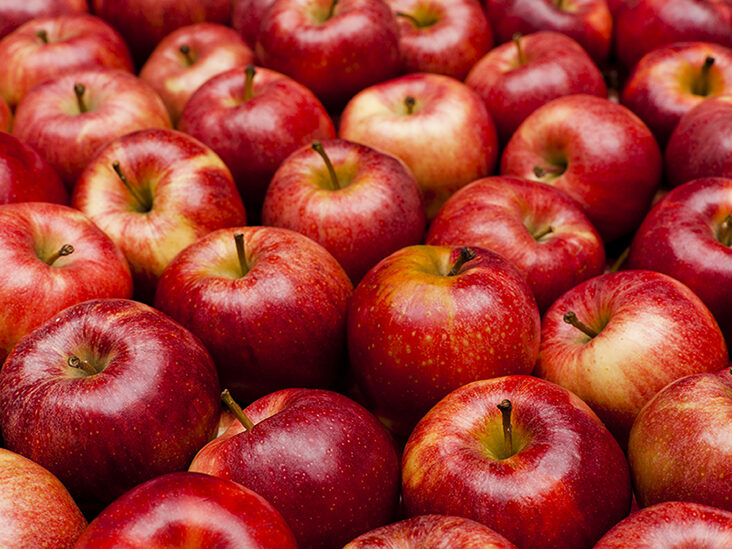

In [6]:
# here we can see our image
image

In [8]:
# here we can see what preprocessing our image looks like.
# using the necessary functions, a tensor is returned.
device = "cpu"
preprocess(image).unsqueeze(0).to(device)

tensor([[[[-0.9164, -0.0988,  0.3537,  ...,  0.3537,  0.5727,  0.7041],
          [-0.9893, -0.2594,  0.2369,  ...,  0.3391,  0.5289,  0.6311],
          [-1.0623, -0.4346,  0.0179,  ...,  0.3245,  0.4705,  0.6457],
          ...,
          [ 0.7917,  0.8209,  0.8647,  ...,  1.2588,  1.3610,  1.3902],
          [ 0.7771,  0.8647,  0.8501,  ...,  1.4194,  1.1858,  1.2296],
          [ 0.8063,  0.8792,  0.8938,  ...,  1.2880,  1.3172,  1.3026]],

         [[-1.7221, -1.7221, -1.4219,  ..., -1.2869, -1.2869, -1.4369],
          [-1.7221, -1.7371, -1.4970,  ..., -1.3169, -1.4069, -1.6320],
          [-1.7221, -1.7521, -1.5570,  ..., -1.4820, -1.6621, -1.7521],
          ...,
          [-1.6771, -1.7371, -1.7521,  ..., -0.5215, -0.4614, -0.1313],
          [-1.7521, -1.7371, -1.7521,  ..., -0.3864, -0.8066, -0.7916],
          [-1.7521, -1.7521, -1.7521,  ..., -0.8666, -0.8666, -0.6415]],

         [[-1.3665, -1.3665, -1.2954,  ..., -0.9683, -0.8972, -0.9114],
          [-1.3665, -1.3522, -

In [9]:
# applying the necessary transformation, and resaving into `image_input` variable
image_input = preprocess(image).unsqueeze(0).to(device)

To process the text for the model, we use `clip.tokenize(text: Union[str, List[str]], context_length=77)` which returns a LongTensor containing tokenized sequences of given text input(s). This can be used as the input to the model.

In [10]:
# for example
clip.tokenize(["a diagram", "a photo of a cat", "a photo of a dog"])

tensor([[49406,   320, 22697, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320,  1125,   539,   320,  2368, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

So just a quick remark about how tokenize seems to work. It takes in a list of strings, which are essentially labels for the model. Then it 'tokenizes' the strings, mapping each english word to a corresponding number that CLIP recognizes. The numbers 49406 and 49407 seem to correspond to some sort of code for the beginning of the text label and the end, hence 49406 appears at the start of each tokenized list and 49407 at the end.

In [11]:
# using a list comprehension, we tokenize all labels in the data set with the 
# prefix "a photo of a {}", the concatenate the tensors into a list of lists.
torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes])

tensor([[49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        ...,
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0]], dtype=torch.int32)

In [12]:
# now resave tokenized text into `text_input` variable
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes])

In [13]:
# `torch.no_grad()` disables gradient calculation, seems to be for memory optimization
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
    
    logits_per_image, logits_per_text = model(image_input, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

We now get a list of image features and text features. Not entirely sure what these represent.

Using the function `model()` with the `image_input` and `text_input` arguments, we get

In [14]:
# Pick the top 5 most similar labels for the image
# these 2 lines normalize the vectors image_features and text_features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# this line multiplies the two matrices image_features and text_features
# then transposes it and scalar multiplies by 100. Then the .softmax()
# method applies the softmax function so every entry in the tensor sums to 1
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# then pick the 5 largest elements of the tensor.
values, indices = similarity[0].topk(5)

Now all we have left to do is print the results.

In [15]:
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    # this line finds the label and prints it next to the corresponding
    # probability the image has that label.
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

           apple: 98.16%
           plain: 0.48%
            bowl: 0.20%
    sweet_pepper: 0.17%
      maple_tree: 0.13%
